# High order epistasis in protein lattice folding stability

In [1]:
%matplotlib inline
import numpy as np
import os
import scipy.stats
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams["font.family"] = "Arial"
mpl.rcParams["font.size"] = 10

from ipywidgets import interact
# Lattice protein module
from latticeproteins.sequences import * 
from latticeproteins.conformations import *
from latticegpm import svg

# Lattice sequence space mapping utils
from latticegpm.utils import search_conformation_space, fold_energy
from latticegpm.space import LatticeConformationSpace

# Epistasis modelling package imports 
from epistasis.models.linear import LinearEpistasisModel
from epistasis.models.specifier import LinearEpistasisSpecifier

## Lattice protein sequence space

Specify the length of sequences, the number of conformations in space, and the number of mutations in the space.

In [2]:
length=12

database_dir = "database/"
conformations = Conformations(length, database_dir)#, interaction_energies=HP)

In [3]:
# Select two protein sequences that fold.
s1 = 'YMQTKDVKWDRH'
s2 = 'YCTTKPQKHDCH'

# Set the temperature of the system.
temperature = 0.1

# Construct a sequence space
full_seqspace = LatticeConformationSpace(s1, s2, conformations, temperature=temperature)

# 
genotypes = full_seqspace.genotypes
phenotypes = full_seqspace.phenotypes

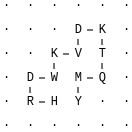

In [4]:
mapping = full_seqspace.get_map("genotypes", "confs")
s1conf = svg.Configuration(s1, mapping[s1], fontsize=12, filename="conf1-talk.svg")
s1conf.notebook
#s1conf.save()

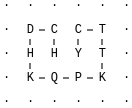

In [5]:
s2conf = svg.Configuration(s2, mapping[s2], fontsize=12,filename="conf2-talk.svg")
s2conf.notebook
#s2conf.save()

## Linear epistasis model

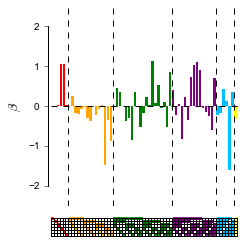

In [6]:
local = LinearEpistasisModel(s1, genotypes, phenotypes)
local.fit()
fig, ax = local.Plot.interactions(sigmas=0, figsize=[3.5,3.5], height_ratio=10, ybounds=(-2.5,2.5))
ax[0].set_ylabel("$\\beta$")
#fig.savefig(out_path + "epistasis-lattice-full.svg", format="svg")

### Model specifier

In [9]:
specifier = LinearEpistasisSpecifier(s1, genotypes, phenotypes)
specifier.fit()
print(specifier.StatisticalTest.p_value)
print(specifier.StatisticalTest.order)

0.747458821171
3


### Two state lattice model

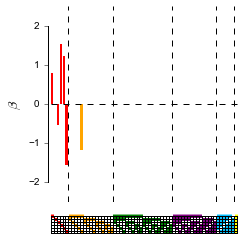

In [57]:
z = list(full_seqspace.unique_confs)[0:1]
phenotypes = full_seqspace.redefine_partition(z)

local = LinearEpistasisModel(s1, genotypes, phenotypes)
local.fit()
fig, ax = local.Plot.interactions(sigmas=0, figsize=[3.5,3.5], height_ratio=8, ybounds=(-2.5,2.5))
ax[0].set_ylabel("$\\beta$")
#fig.savefig(out_path + "epistasis-lattice-2state.svg", format="svg")

### Three state lattice model

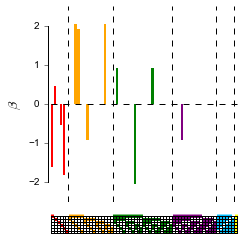

In [58]:
z = list(full_seqspace.unique_confs)[0:2]
phenotypes = full_seqspace.redefine_partition(z)
local = LinearEpistasisModel(s1, genotypes, phenotypes)
local.fit()
fig, ax = local.Plot.interactions(sigmas=0, figsize=[3.5,3.5], height_ratio=8, ybounds=(-2.5,2.5))
ax[0].set_ylabel("$\\beta$")
#fig.savefig(out_path + "epistasis-lattice-3state.svg", format="svg")

# High-order epistasis in fraction folded phenotype (saturates)

Another observable phenotype in lattice model is fraction folded. 

$$
F(\Delta G, T) = \frac{1}{1 + e^{\Delta G / T}}
$$

In [69]:
def fraction_folded(stability, T=1.0):
    """ Calculate fraction unfolded. """
    return  1.0 / (1.0 + np.exp(stability/T))

In [70]:
new_seqspace = LatticeConformationSpace(s1, s2, conformations, temperature=temperature)
new_seqspace.phenotypes = fraction_folded(new_seqspace.phenotypes, T=temperature)

sat_genotypes = new_seqspace.genotypes
sat_phenotypes = new_seqspace.phenotypes

## Linear epistasis model

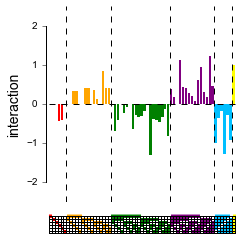

In [84]:
local = LinearEpistasisModel(s1, sat_genotypes, sat_phenotypes)
local.fit()
local.Plot.interactions(sigmas=0, figsize=[3.5,3.5], height_ratio=8, ybounds=(-2.5,2.5))
ax[0].set_ylabel("$\\beta$")
#fig.savefig(out_path + "epistasis-lattice-full.svg", format="svg")

## Nonlinear epistasis model

In [62]:
from epistasis.models.nonlinear import NonlinearEpistasisModel

In [63]:
def saturation(x, saturation, rate):
    """ Saturation function where X is the linear epistasis model. """
    y = (saturation  * x / ( x + rate ))
    return y

R-squared of fit: 0.992695010455
rate: 5.82167803646e-05
saturation: 0.996578146445


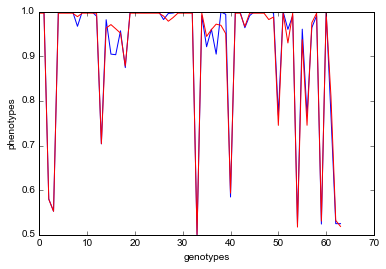

In [66]:
nonlinear = NonlinearEpistasisModel(s1, sat_genotypes, sat_phenotypes, 
    order=2, # Note second order epistasis is included, since we know lattice proteins are second-order systems
    function=saturation)


# Use fitting widget to easily fit data
nonlinear.fit_widget(saturation=(0,1, .1), rate=(0,10))

(<matplotlib.figure.Figure at 0x110a56d68>,
  <matplotlib.axes._subplots.AxesSubplot at 0x11144a0f0>])

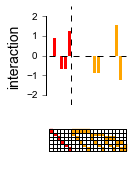

In [74]:
nonlinear.Plot.interactions(sigmas=0, height_ratio=2, figsize=(2,2.5), ybounds=(-2.5,2.5))

(<matplotlib.figure.Figure at 0x110a71ef0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x110764e10>)

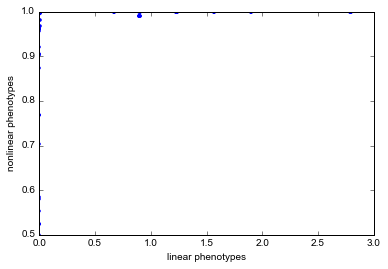

In [75]:
nonlinear.Plot.linear_phenotypes()